In [28]:
# Database imports:
from sqlalchemy.engine import URL
from langchain_community.utilities import SQLDatabase

# Environment imports:
from dotenv import load_dotenv

# Langchain Imports:
from langchain_groq import ChatGroq
from pydantic import BaseModel,Field
from typing import TypedDict,Annotated
from langchain_core.messages import SystemMessage,HumanMessage,BaseMessage

# Langgraph Imports:
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [29]:
load_dotenv()

True

In [30]:
model=ChatGroq(model="llama-3.1-8b-instant")

In [ ]:
# Connection with the database
url=URL.create(
    drivername='mysql+pymysql',
    username="root",
    password="******",
    host="127.0.0.1",
    port=3306,
    database="practise"
)

db=SQLDatabase.from_uri(url)

tables=db.get_usable_table_names()
print("Database Successfully Connected")
print(f"Thr tables are: {tables}")


Database Successfully Connected
Thr tables are: ['ipl_ball_by_ball_2008_2022', 'movies', 'smartphones']


In [32]:
class StateSchema(TypedDict):
    schema:str
    natural_language:str
    sql_query:str

    confidence_score:float
    feedback:list[str]

    iterator:int

In [33]:
class SQLSchema(BaseModel):
    sql_query: str = Field(..., description="SQL query to answer the question (SELECT only).")
    confidence_score: float = Field(..., ge=0.0, le=1.0)
    feedback: str = Field(..., description="Assumptions, ambiguity, or reasons for uncertainty.")

In [34]:
model1=model.with_structured_output(SQLSchema)

In [35]:
db.get_table_info()

'\nCREATE TABLE ipl_ball_by_ball_2008_2022 (\n\t`ID` INTEGER, \n\tinnings INTEGER, \n\tovers INTEGER, \n\tballnumber INTEGER, \n\tbatter TEXT, \n\tbowler TEXT, \n\t`non-striker` TEXT, \n\textra_type TEXT, \n\tbatsman_run INTEGER, \n\textras_run INTEGER, \n\ttotal_run INTEGER, \n\tnon_boundary INTEGER, \n\t`isWicketDelivery` INTEGER, \n\tplayer_out TEXT, \n\tkind TEXT, \n\tfielders_involved TEXT, \n\t`BattingTeam` TEXT\n)DEFAULT CHARSET=utf8mb4 ENGINE=InnoDB COLLATE utf8mb4_0900_ai_ci\n\n/*\n3 rows from ipl_ball_by_ball_2008_2022 table:\nID\tinnings\tovers\tballnumber\tbatter\tbowler\tnon-striker\textra_type\tbatsman_run\textras_run\ttotal_run\tnon_boundary\tisWicketDelivery\tplayer_out\tkind\tfielders_involved\tBattingTeam\n1312200\t1\t0\t1\tYBK Jaiswal\tMohammed Shami\tJC Buttler\tNA\t0\t0\t0\t0\t0\tNA\tNA\tNA\tRajasthan Royals\n1312200\t1\t0\t2\tYBK Jaiswal\tMohammed Shami\tJC Buttler\tlegbyes\t0\t1\t1\t0\t0\tNA\tNA\tNA\tRajasthan Royals\n1312200\t1\t0\t3\tJC Buttler\tMohammed Shami\

In [36]:
def load_schema(state:StateSchema):
    schema=db.get_table_info()
    return {
        "schema":schema
    }

def translate(state: StateSchema):
    sys_instr = SystemMessage(content=(
        "You are an SQL expert. Given a natural language question and database schema, "
        "generate a SQL query that answers the question.\n\n"
        "Rules:\n"
        "- Use only tables/columns that exist in the schema.\n"
        "- Prefer explicit JOINs.\n"
        "- Add LIMIT 10 unless user requests more.\n"
        "- feedback/concern if you are not hundred percent sure or the question is ambigious else I am confident.\n"
        f"\nSCHEMA:\n{state['schema']}"
    ))
    human_msg = HumanMessage(content=state['natural_language'])  
    
    response = model1.invoke([sys_instr, human_msg])
    
    return {
        "sql_query": response.sql_query,
        "feedback": state["feedback"]+[response.feedback],  
        "confidence_score": float(response.confidence_score)
    }

def optimize(state: StateSchema):
    sys_instr = SystemMessage(content=(
        "You are an expert SQL engineer for a MySQL database.\n"
        "Refine the SQL query to correctly answer the user question.\n\n"
        "Rules:\n"
        "- SELECT only.\n"
        "- Use only tables/columns from the schema.\n"
        "- Fix errors using the execution_error.\n"
        "- Add LIMIT 10 unless user requests more.\n"
        "- Output fields: sql_query, confidence_score (0-1), feedback.\n\n"
        f"SCHEMA:\n{state['schema']}"
    ))
    last_feedback=state["feedback"][-1] if state["feedback"] else ""
    last_sql_query=state["sql_query"]
    human_msg = HumanMessage(content=f"Natural Question{state['natural_language']},SQL Query:{last_sql_query},Feedback:{last_feedback}")  
    
    response = model1.invoke([sys_instr, human_msg])
    iterator=state["iterator"]+1
    
    return {
        "sql_query": response.sql_query,
        "feedback": state["feedback"]+[response.feedback],  
        "confidence_score": float(response.confidence_score),
        "iterator":iterator
    }

def condition_check(state):

    if state["confidence_score"]<0.8 or state["iterator"]<3:
        return "rejected"
    else:
        return "approved"
    

In [37]:
graph=StateGraph(StateSchema)

In [38]:
graph.add_node('load_schema',load_schema)
graph.add_node('translate',translate)
graph.add_node('optimize',optimize)

graph.add_edge(START,'load_schema')
graph.add_edge('load_schema','translate')
graph.add_conditional_edges('translate',condition_check,{"approved":END,"rejected":'optimize'})
graph.add_conditional_edges("optimize", condition_check, {"approved": END, "rejected": "optimize"})


workflow=graph.compile()

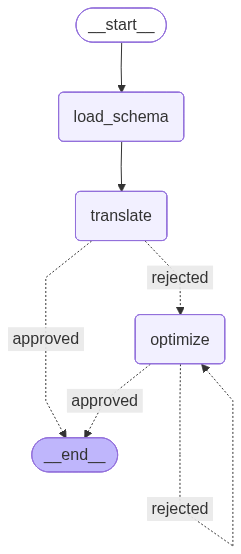

In [39]:
workflow

In [40]:
initial_state: StateSchema = {
    "natural_language": "Can you query the most popular apple phone by rating",
    "schema": "",
    "sql_query": "",
    "confidence_score": 0.0,
    "feedback": [],
    "iterator": 0,
}

final = workflow.invoke(initial_state)
print(final["sql_query"])
print(final["confidence_score"])
print(final["feedback"][-1] if final["feedback"] else "")

SELECT * FROM smartphones WHERE brand_name = 'apple' ORDER BY rating DESC LIMIT 1
1.0
Based on the given schema, this query will fetch the most popular apple phone by rating.
